In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [3]:
df_sign = pd.read_csv(params.sign_csv, index_col=0, parse_dates=True) 

# Collect each day’s feature-engineered frame
frames = []
print('generating main features...')
for day, day_df in df_sign.groupby(df_sign.index.normalize()):
    # day_df has only that session’s bars
    feats_main = feats.features_creation(df = day_df, 
                                         ma_window = 20) # sma window for ATR and Volume
    frames.append(feats_main)

# Re-assemble back into one long DF
df_feat_main = pd.concat(frames).sort_index()

print('generating engineered features...')
df_feat_eng = feats.features_engineering(
                                        df = df_feat_main,
                                        low_rsi = 30,
                                        high_rsi = 70,
                                        adx_thresh = 20,
                                        adx_window = 7
                                        )

df_feat_eng

generating main features...
generating engineered features...


,ema,sma,macd_line,macd_signal,macd_diff,bb_lband,bb_hband,bb_width_20,rsi,plus_di,minus_di,adx,atr_14,atr_sma,atr_ratio,atr_ratio_sma,obv,obv_sma,vwap_dev,r_1,r_5,r_15,vol_15,volume_spike,stoch_k_14,stoch_d_3,hour,day_of_week,month,open,high,low,close,volume,bid,ask,signal,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div
2004-01-02 13:09:00,0.764272,0.764282,-0.000007,-0.000002,-0.000005,0.764255,0.764307,0.000068,0.000000,0.000000,100.000000,19.934402,0.000003,3.419596e-07,0.000004,4.474464e-07,6791837.50,6.713853e+06,-0.000056,-0.000022,-0.000066,-0.000066,0.000008,1.602274,0.000000,0.000000,13,4,1,0.764235,0.764235,0.764235,0.764235,48081.25,0.763664,0.764807,0.178482,-0.000,-0.000,0.00,30.0,0.000,7.798438e+04,0.0
2004-01-02 13:10:00,0.764264,0.764279,-0.000011,-0.000004,-0.000007,0.764240,0.764315,0.000098,0.000000,0.000000,100.000000,25.653374,0.000004,5.566920e-07,0.000006,7.284294e-07,6737062.50,6.727306e+06,-0.000071,-0.000022,-0.000088,-0.000088,0.000009,1.747383,0.000000,0.000000,13,4,1,0.764219,0.764219,0.764219,0.764219,54775.00,0.763647,0.764790,0.185947,-0.000,-0.000,0.00,30.0,-0.000,9.756250e+03,0.0
2004-01-02 13:11:00,0.764254,0.764276,-0.000015,-0.000006,-0.000009,0.764224,0.764323,0.000130,0.000000,0.000000,100.000000,30.963847,0.000005,8.158760e-07,0.000007,1.067586e-06,6675593.75,6.736286e+06,-0.000083,-0.000022,-0.000110,-0.000110,0.000010,1.861544,0.000000,0.000000,13,4,1,0.764202,0.764202,0.764202,0.764202,61468.75,0.763631,0.764773,0.193731,-0.000,-0.000,0.00,30.0,-0.000,-6.069219e+04,0.1
2004-01-02 13:12:00,0.764244,0.764272,-0.000019,-0.000009,-0.000010,0.764206,0.764330,0.000163,0.000000,0.000000,100.000000,35.895001,0.000006,1.116336e-06,0.000008,1.460763e-06,6607431.25,6.740458e+06,-0.000094,-0.000022,-0.000110,-0.000131,0.000010,1.945919,0.000000,0.000000,13,4,1,0.764185,0.764185,0.764185,0.764185,68162.50,0.763614,0.764757,0.201848,-0.000,-0.000,0.00,30.0,-0.000,-1.330262e+05,0.1
2004-01-02 13:13:00,0.764232,0.764268,-0.000024,-0.000012,-0.000012,0.764187,0.764337,0.000197,0.000000,0.000000,100.000000,40.473929,0.000007,1.455125e-06,0.000009,1.904106e-06,6532575.00,6.739486e+06,-0.000103,-0.000022,-0.000110,-0.000153,0.000011,2.003044,0.000000,0.000000,13,4,1,0.764169,0.764169,0.764169,0.764169,74856.25,0.763597,0.764740,0.210311,-0.000,-0.000,0.00,30.0,-0.000,-2.069112e+05,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.464247,196.252523,0.175662,0.134526,0.041136,195.926584,196.725006,0.004067,67.216594,36.312473,7.485222,30.194416,0.250991,1.852786e-01,0.001275,9.435851e-04,4282659.00,3.181866e+06,0.001768,0.000635,0.002846,0.003639,0.000724,1.952858,72.169811,62.051653,20,2,6,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.729956,0.212,0.041,-0.09,0.0,10.194,1.100793e+06,3.3
2025-06-18 20:57:00,196.496671,196.279250,0.179462,0.143513,0.035949,195.924930,196.772160,0.004315,61.668579,34.720671,6.704415,32.868467,0.260206,1.893612e-01,0.001323,9.642380e-04,3822029.00,3.224389e+06,0.000877,-0.000712,0.001450,0.003081,0.000746,2.143635,58.567483,64.412431,20,2,6,196.810000,196.940000,196.560000,196.675000,460630.00,196.527500,196.822500,0.710346,0.217,0.036,0.00,0.0,12.868,5.976403e+05,3.6
2025-06-18 20:58:00,196.523337,196.306558,0.179996,0.150810,0.029186,195.925348,196.812742,0.004519,61.473426,33.627161,6.493263,35.351515,0.249477,1.930490e-01,0.001269,9.828957e-04,3296784.00,3.234595e+06,0.000715,-0.000025,0.000559,0.002291,0.000747,2.234218,58.091247,62.942847,20,2,6,196.675000,196.740000,196.630000,196.670000,525245.00,196.522500,196.817500,0.683383,0.217,0.029,0.00,0.0,15.352,6.218915e+04,2.9
2025-06-18 20:59:00,196.479747,196.318096,0.144060,0.149460,-0.005400,195.922319,196.812771,0.004535,47.540108,29.057762,16.002074,34.895986,0.268085,1.979733e-01,0.001366,1.007996e-03,1221281.00,3.1365

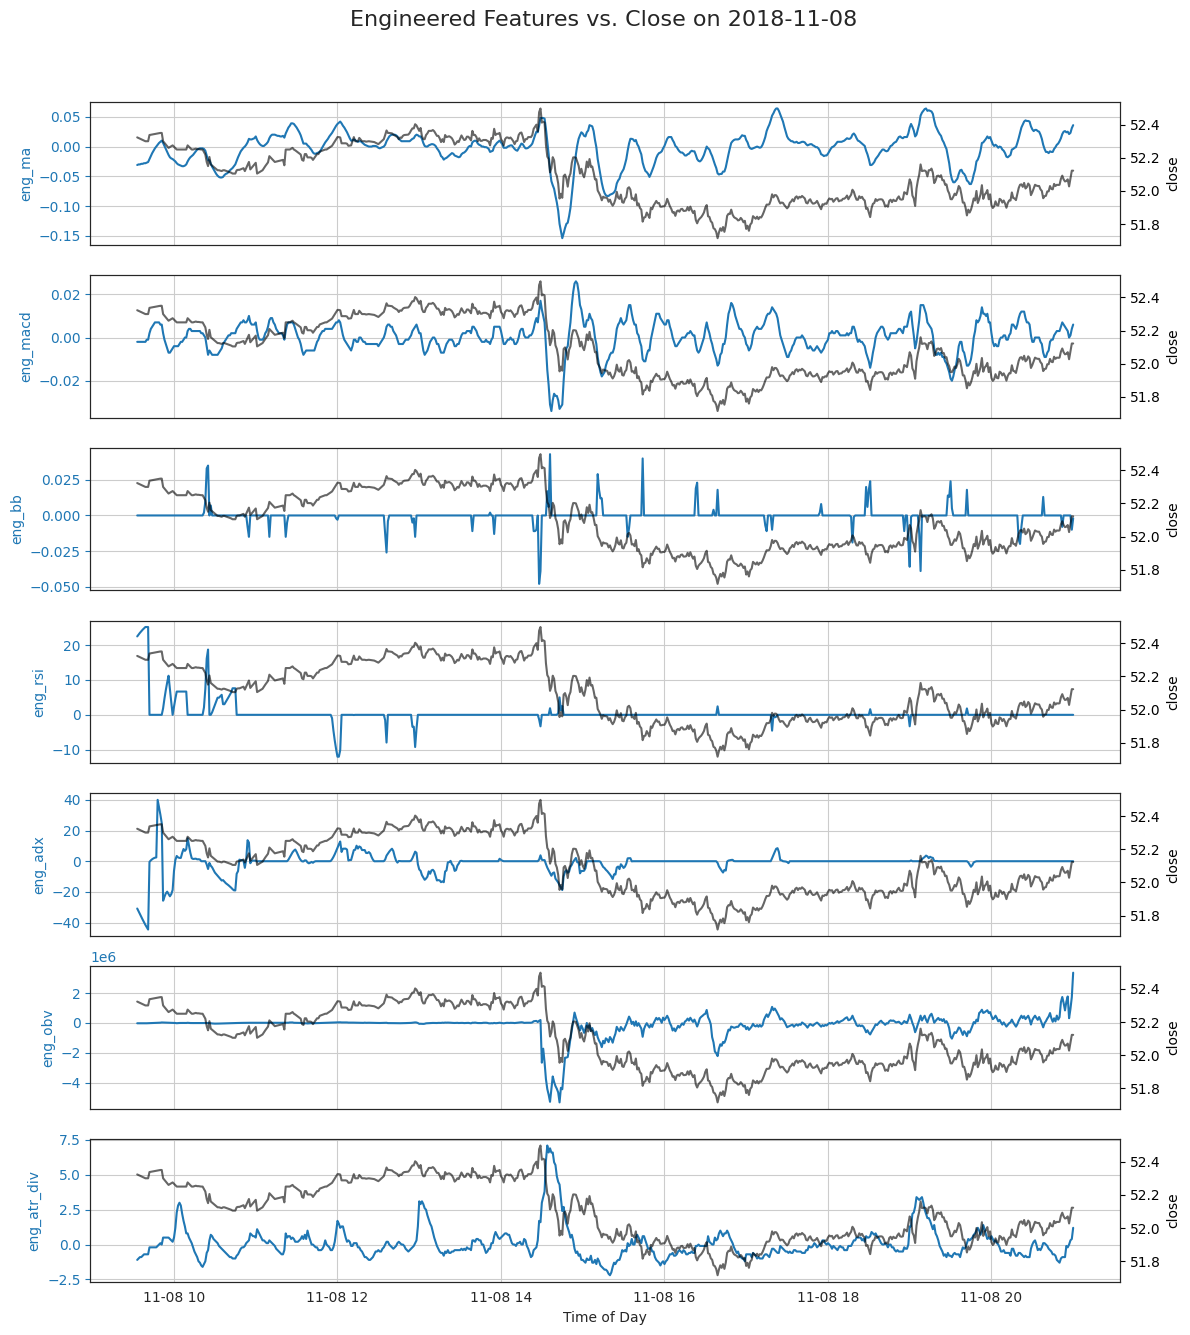

In [4]:
# 1) Identify engineered‐feature columns and the raw close price column
eng_features = [c for c in df_feat_eng.columns if c.startswith("eng_")]
close_col    = "close"

# 2) Pick a random trading day and convert to pandas Timestamp
all_days   = df_feat_eng.index.normalize().unique()
random_day = np.random.choice(all_days)
day_ts     = pd.to_datetime(random_day)

# 3) Subset the DataFrame to that single day
mask         = df_feat_eng.index.normalize() == random_day
df_day_feats = df_feat_eng.loc[mask, eng_features]
df_day_close = df_feat_eng.loc[mask, close_col]

# 4) Create one subplot per engineered feature
fig, axes = plt.subplots(
    nrows   = len(eng_features),
    ncols   = 1,
    figsize = (12, 2 * len(eng_features)),
    sharex  = True
)
fig.suptitle(f"Engineered Features vs. Close on {day_ts.date()}", fontsize=16)

# 5) Plot each feature on its own left‐y axis, and close price on a right‐y axis
for ax, feat in zip(axes, eng_features):
    # left axis: engineered feature
    ax.plot(df_day_feats.index, df_day_feats[feat],
            color="C0", label=feat)
    ax.set_ylabel(feat, color="C0")
    ax.tick_params(axis="y", colors="C0")
    ax.grid(True)

    # right axis: raw close price
    ax2 = ax.twinx()
    ax2.plot(df_day_close.index, df_day_close,
             color="k", alpha=0.6, label="close")
    ax2.set_ylabel("close", color="k")
    ax2.tick_params(axis="y", colors="k")

# 6) Final formatting
axes[-1].set_xlabel("Time of Day")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


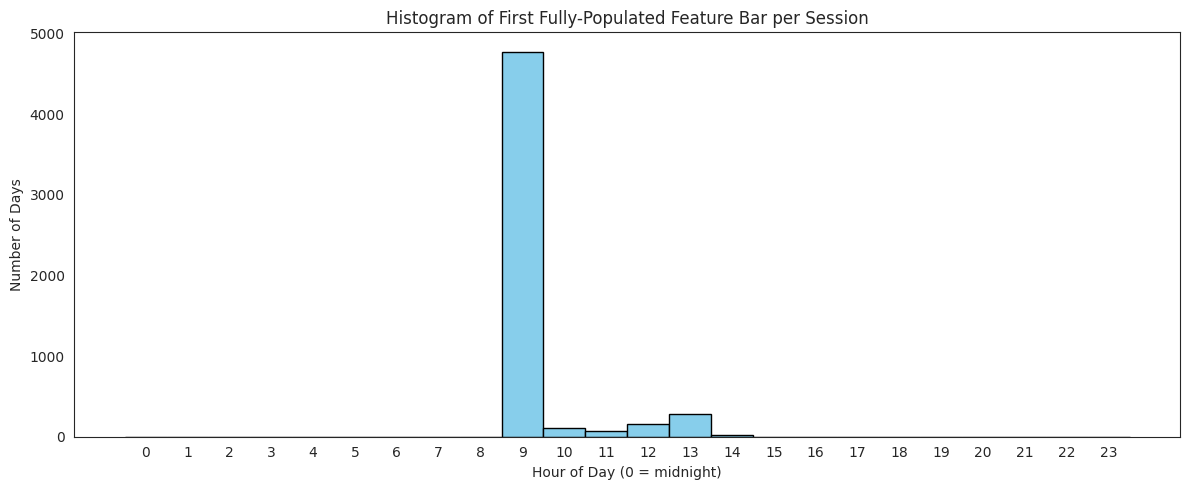

In [5]:
# -----------------------------------------------------------------------------
# What this plot shows:
#   We measure, for each trading day, the first 1-minute bar when *every* feature has a non-null value.  
#   Plotting the histogram of those hours tells how long the indicators take to “warm up” each morning before the model can run.
# -----------------------------------------------------------------------------

# 1) Prepare a DataFrame without bid/ask (and any non-feature cols)
df_feat_unsc = df_feat_eng.drop(columns=["bid", "ask"], errors="ignore")

# 2) Identify all feature columns (those starting with "feat_")
feat_cols = [c for c in df_feat_unsc.columns if c != 'signal']

# 3) For each calendar day, find the first timestamp where *all* feat_ cols are non-null
first_valid = (
    df_feat_unsc
      .groupby(df_feat_unsc.index.normalize())
      .apply(lambda grp: grp.dropna(subset=feat_cols).index.min())
)

# 4) Extract the hour (0–23) of that first fully-populated bar
first_valid_hours = first_valid.dt.hour

# 5) Plot the histogram
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),       # 24 one-hour bins
    align='left',
    color='skyblue',
    edgecolor='black'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Populated Feature Bar per Session')
plt.tight_layout()
plt.show()


In [11]:
importlib.reload(feats) ############################

# feed the trimmed DataFrame into the existing call
df_feat_all = feats.scale_with_splits(
    df           = df_feat_eng,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)
df_feat_all

Scaling splits:   0%|          | 0/3 [00:00<?, ?split/s]

PCA compress:   0%|          | 0/3 [00:00<?, ?feat/s]

,bb_lband,bb_hband,atr_14,atr_sma,obv,obv_sma,open,high,low,close,volume,r_1,r_5,r_15,vol_15,bb_width_20,rsi,atr_ratio,atr_ratio_sma,vwap_dev,volume_spike,stoch_k_14,stoch_d_3,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,ema,sma,macd_line,macd_signal,macd_diff,plus_di,minus_di,adx,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:09:00,-0.593013,-0.593777,-0.568706,-0.568166,0.552276,0.591224,-0.593462,-0.593513,-0.593371,-0.593450,-0.193587,-0.028007,-0.041052,-0.025455,-1.513065,-1.631295,-2.540612,-1.628932,-1.630878,-0.038000,0.979241,-1.782005,-1.878188,-0.002684,0.003780,-0.008623,3.146868,-0.015779,-0.035115,-0.017133,-1.164969,-1.164969,-0.002573,-0.002829,0.000274,0.000000,100.000000,19.934402,0.496,-0.976,0.693,0.763664,0.764807,0.178482
2004-01-02 13:10:00,-0.593013,-0.593776,-0.568627,-0.568148,0.547407,0.592512,-0.593463,-0.593514,-0.593371,-0.593451,-0.185411,-0.028007,-0.054489,-0.033415,-1.508712,-1.608061,-2.540612,-1.624994,-1.629989,-0.046879,1.119269,-1.782005,-1.878188,-0.002684,0.003780,-0.008623,3.146868,-0.015779,-0.050160,-0.017133,-1.164970,-1.164969,-0.002867,-0.002971,-0.000259,0.000000,100.000000,25.653374,0.496,-0.976,0.693,0.763647,0.764790,0.185947
2004-01-02 13:11:00,-0.593014,-0.593776,-0.568553,-0.568126,0.541942,0.593372,-0.593463,-0.593514,-0.593372,-0.593451,-0.177236,-0.028008,-0.067927,-0.041376,-1.505368,-1.583325,-2.540612,-1.621341,-1.628916,-0.054488,1.219768,-1.782005,-1.878188,-0.002684,0.003780,-0.008623,3.146868,-0.015779,-0.066092,0.024765,-1.164970,-1.164969,-0.003194,-0.003154,-0.000772,0.000000,100.000000,30.963847,0.496,-0.976,0.693,0.763631,0.764773,0.193731
2004-01-02 13:12:00,-0.593015,-0.593776,-0.568485,-0.568101,0.535882,0.593772,-0.593464,-0.593515,-0.593373,-0.593452,-0.169061,-0.028009,-0.067928,-0.049337,-1.502813,-1.557610,-2.540612,-1.617951,-1.627673,-0.060920,1.289201,-1.782005,-1.878188,-0.002684,0.003780,-0.008623,3.146868,-0.015779,-0.082541,0.024765,-1.164971,-1.164970,-0.003542,-0.003375,-0.001239,0.000000,100.000000,35.895001,0.496,-0.976,0.693,0.763614,0.764757,0.201848
2004-01-02 13:13:00,-0.593016,-0.593775,-0.568421,-0.568073,0.529228,0.593679,-0.593465,-0.593516,-0.593374,-0.593453,-0.160885,-0.028009,-0.067930,-0.057298,-1.500920,-1.531356,-2.540612,-1.614806,-1.626271,-0.066308,1.334067,-1.782005,-1.878188,-0.002684,0.003780,-0.008623,3.146868,-0.015779,-0.099356,0.024765,-1.164972,-1.164970,-0.003903,-0.003629,-0.001647,0.000000,100.000000,40.473929,0.496,-0.976,0.693,0.763597,0.764740,0.210311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,8.017492,8.033390,20.274207,14.952906,0.329208,0.253040,8.041149,8.047024,8.041122,8.047119,0.218757,0.838878,1.745065,1.321156,0.712131,0.538028,0.745702,0.921854,0.489243,1.066933,1.294741,0.667637,0.433195,12.490735,10.465010,-27.287099,0.046161,0.374003,0.189616,1.311532,12.666013,12.651066,13.879537,11.321438,10.779086,36.312473,7.485222,30.194416,-0.947,0.032,-0.246,196.667400,196.962600,0.729956
2025-06-18 20:57:00,8.017419,8.035466,21.039451,15.294912,0.288257,0.257111,8.046878,8.050550,8.038036,8.040948,0.310278,-0.939688,0.888837,1.118126,0.757680,0.623661,0.489061,0.977384,0.520556,0.527294,1.437764,0.353783,0.493668,12.791413,9.216155,-0.008623,0.046161,0.475550,0.079144,1.428989,12.668304,12.652955,14.179841,12.077968,9.420073,34.720671,6.704415,32.868467,-0.947,0.032,-0.246,196.527500,196.822500,0.710346
2025-06-18 20:58:00,8.017437,8.037253,20.148477,15.603843,0.241563,0.258088,8.040928,8.041737,8.041122,8.040728,0.389196,-0.032651,0.342451,0.830934,0.758348,0.690980,0.480010,0.913831,0.548419,0.429395,1.499954,0.342322,0.456113,12.791413,7.455464,-0.008623,0.046161,0.569742,-0.038595,1.154319,12.670189,12.654885,14.221985,12.692171,7.648141,33.627161,6.493263,35.351515,-0.947,0.032,-0.246,196.522500,196.817500,0.683383
2025-06-18

saving df …


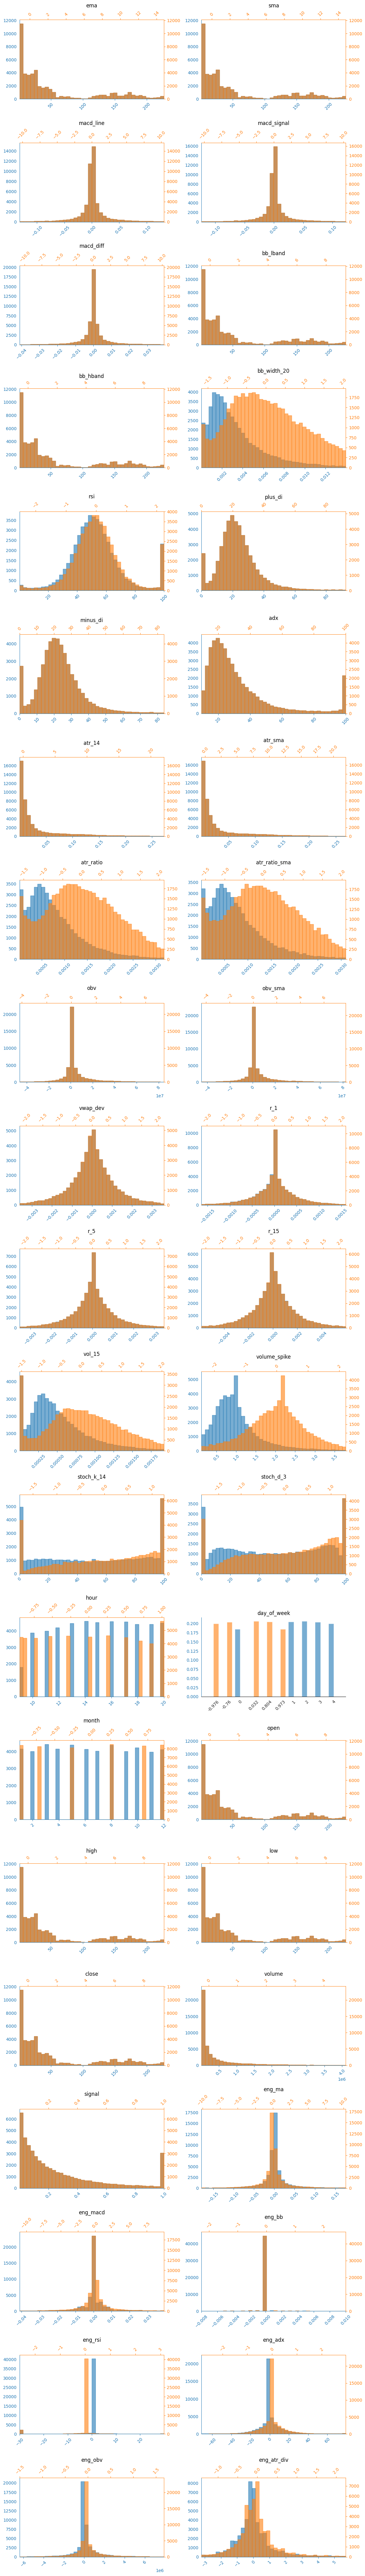

In [12]:
df_feat_scal = df_feat_all.drop(['bid','ask'], axis=1)

plots.plot_dual_histograms(
    df_before = df_feat_unsc,
    df_after  = df_feat_scal,
)

In [ ]:
print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask